# **Laboratorio 3**

Edwin Ortega, 22305 - Esteban Zambrano, 22119 - Juan Pablo Solis, 22102


### **Ejercicio 1**

In [1]:
import numpy as np
from dataclasses import dataclass
from typing import Callable, List, Tuple, Optional, Dict

Array = np.ndarray

@dataclass
class OptResult:
    best: Array
    xs: List[Array]
    fs: List[float]
    errs: List[float]
    iters: int
    converged: bool
    meta: Dict[str, float] = None

def _norm(v: Array) -> float:
    return float(np.linalg.norm(v))

def _compute_error(kind: str,
                   xk: Array, xk1: Array,
                   fk: float, fk1: float,
                   gk1: Array) -> float:
    kind = kind.lower()
    if kind == "grad_norm":
        return _norm(gk1)
    elif kind == "x_diff":
        return _norm(xk1 - xk)
    elif kind == "f_diff":
        return abs(fk1 - fk)
    else:
        # Por defecto, norma del gradiente
        return _norm(gk1)

def _as_array(x0: Array) -> Array:
    x0 = np.asarray(x0, dtype=float).reshape(-1)
    return x0

# ============= Descenso "naïve" con dirección de descenso aleatoria =============
def gd_random_direction(
    f: Callable[[Array], float],
    grad: Callable[[Array], Array],
    x0: Array,
    alpha: float,
    maxIter: int,
    eps: float,
    stop_criterion: str = "grad_norm",
    rng: Optional[np.random.Generator] = None
) -> OptResult:
    """
    En cada iteración elige una dirección unitaria aleatoria u y toma d = -u o +u
    de modo que sea de descenso (∇f(x)^T d < 0). Paso constante α.
    """
    if rng is None:
        rng = np.random.default_rng()

    xk = _as_array(x0)
    xs, fs, errs = [xk.copy()], [float(f(xk))], []
    converged = False

    for k in range(1, maxIter + 1):
        gk = grad(xk)

        # Dirección aleatoria unitaria
        u = rng.normal(size=xk.size)
        u /= max(_norm(u), 1e-12)

        # Elegir el signo para que sea dirección de descenso
        if np.dot(gk, u) > 0:
            d = -u
        else:
            d = u

        xk1 = xk + alpha * d
        fk, fk1 = fs[-1], float(f(xk1))
        gk1 = grad(xk1)

        err = _compute_error(stop_criterion, xk, xk1, fk, fk1, gk1)
        xs.append(xk1.copy())
        fs.append(fk1)
        errs.append(err)

        xk = xk1
        if err < eps:
            converged = True
            break

    return OptResult(best=xk, xs=xs, fs=fs, errs=errs, iters=len(errs), converged=converged,
                     meta={"alpha": alpha})

# ============= Descenso máximo (steepest descent) naïve =============
def steepest_descent(
    f: Callable[[Array], float],
    grad: Callable[[Array], Array],
    x0: Array,
    alpha: float,
    maxIter: int,
    eps: float,
    stop_criterion: str = "grad_norm"
) -> OptResult:
    """
    d_k = -∇f(x_k). Paso constante α.
    """
    xk = _as_array(x0)
    xs, fs, errs = [xk.copy()], [float(f(xk))], []
    converged = False

    for k in range(1, maxIter + 1):
        gk = grad(xk)
        d = -gk
        xk1 = xk + alpha * d

        fk, fk1 = fs[-1], float(f(xk1))
        gk1 = grad(xk1)

        err = _compute_error(stop_criterion, xk, xk1, fk, fk1, gk1)
        xs.append(xk1.copy())
        fs.append(fk1)
        errs.append(err)

        xk = xk1
        if err < eps:
            converged = True
            break

    return OptResult(best=xk, xs=xs, fs=fs, errs=errs, iters=len(errs), converged=converged,
                     meta={"alpha": alpha})

# ============= Newton con Hessiano exacto (paso α) =============
def newton_method(
    f: Callable[[Array], float],
    grad: Callable[[Array], Array],
    hess: Callable[[Array], Array],
    x0: Array,
    alpha: float,
    maxIter: int,
    eps: float,
    stop_criterion: str = "grad_norm",
    ridge: float = 1e-8
) -> OptResult:
    """
    p_k = -H(x_k)^{-1} ∇f(x_k), con regularización 'ridge' si H no es bien condicionado.
    Paso constante α.
    """
    xk = _as_array(x0)
    xs, fs, errs = [xk.copy()], [float(f(xk))], []
    converged = False

    for k in range(1, maxIter + 1):
        gk = grad(xk)
        Hk = hess(xk)

        # Regularización mínima para evitar singularidad
        Hk_reg = Hk + ridge * np.eye(Hk.shape[0])
        try:
            pk = -np.linalg.solve(Hk_reg, gk)
        except np.linalg.LinAlgError:
            pk = -gk

        xk1 = xk + alpha * pk
        fk, fk1 = fs[-1], float(f(xk1))
        gk1 = grad(xk1)

        err = _compute_error(stop_criterion, xk, xk1, fk, fk1, gk1)
        xs.append(xk1.copy())
        fs.append(fk1)
        errs.append(err)

        xk = xk1
        if err < eps:
            converged = True
            break

    return OptResult(best=xk, xs=xs, fs=fs, errs=errs, iters=len(errs), converged=converged,
                     meta={"alpha": alpha})

# ============= Gradiente Conjugado No Lineal (Fletcher–Reeves) con α constante =============
def nonlinear_cg_fr(
    f: Callable[[Array], float],
    grad: Callable[[Array], Array],
    x0: Array,
    alpha: float,
    maxIter: int,
    eps: float,
    stop_criterion: str = "grad_norm"
) -> OptResult:
    """
    Fletcher–Reeves no lineal con tamaño de paso fijo α (naïve).
    p0 = -g0,  x_{k+1} = x_k + α p_k,
    β_{k+1} = ||g_{k+1}||^2 / ||g_k||^2,
    p_{k+1} = -g_{k+1} + β_{k+1} p_k.
    """
    xk = _as_array(x0)
    gk = grad(xk)
    pk = -gk

    xs, fs, errs = [xk.copy()], [float(f(xk))], []
    converged = False

    for k in range(1, maxIter + 1):
        xk1 = xk + alpha * pk
        fk, fk1 = fs[-1], float(f(xk1))
        gk1 = grad(xk1)

        err = _compute_error(stop_criterion, xk, xk1, fk, fk1, gk1)
        xs.append(xk1.copy())
        fs.append(fk1)
        errs.append(err)

        # Actualización FR
        denom = max(np.dot(gk, gk), 1e-32)
        beta = float(np.dot(gk1, gk1) / denom)
        pk = -gk1 + beta * pk

        xk, gk = xk1, gk1
        if err < eps:
            converged = True
            break

    return OptResult(best=xk, xs=xs, fs=fs, errs=errs, iters=len(errs), converged=converged,
                     meta={"alpha": alpha})

# ============= BFGS con α constante (mantiene H_k ≈ (∇^2 f)^{-1}) =============
def bfgs(
    f: Callable[[Array], float],
    grad: Callable[[Array], Array],
    x0: Array,
    alpha: float,
    maxIter: int,
    eps: float,
    stop_criterion: str = "grad_norm"
) -> OptResult:
    """
    BFGS clásico sobre la inversa del Hessiano (H_k).
    p_k = -H_k ∇f(x_k), con paso constante α.
    """
    xk = _as_array(x0)
    n = xk.size
    Hk = np.eye(n)

    fk = float(f(xk))
    gk = grad(xk)

    xs, fs, errs = [xk.copy()], [fk], []
    converged = False

    for k in range(1, maxIter + 1):
        pk = -Hk @ gk
        xk1 = xk + alpha * pk
        fk1 = float(f(xk1))
        gk1 = grad(xk1)

        s = (xk1 - xk).reshape(-1, 1)  # columna
        y = (gk1 - gk).reshape(-1, 1)

        # BFGS update: H_{k+1} = (I - ρ s y^T) H_k (I - ρ y s^T) + ρ s s^T
        ys = float(y.T @ s)
        if ys > 1e-12:  # condición para estabilidad
            rho = 1.0 / ys
            I = np.eye(n)
            Hy = Hk @ y
            Hk = (I - rho * s @ y.T) @ Hk @ (I - rho * y @ s.T) + rho * (s @ s.T)

        err = _compute_error(stop_criterion, xk, xk1, fk, fk1, gk1)
        xs.append(xk1.copy())
        fs.append(fk1)
        errs.append(err)

        xk, fk, gk = xk1, fk1, gk1
        if err < eps:
            converged = True
            break

    return OptResult(best=xk, xs=xs, fs=fs, errs=errs, iters=len(errs), converged=converged,
                     meta={"alpha": alpha})


def run_all_methods(
    f: Callable[[Array], float],
    grad: Callable[[Array], Array],
    x0: Array,
    alpha: float = 1e-3,
    maxIter: int = 5_000,
    eps: float = 1e-6,
    stop_criterion: str = "grad_norm",
    hess: Optional[Callable[[Array], Array]] = None,
    seed: int = 0
) -> Dict[str, OptResult]:
    """
    Ejecuta los cinco métodos (Newton requiere hess) y devuelve un dict con resultados.
    """
    results = {}
    rng = np.random.default_rng(seed)

    results["gd_random"] = gd_random_direction(
        f, grad, x0, alpha, maxIter, eps, stop_criterion, rng=rng
    )

    results["steepest"] = steepest_descent(
        f, grad, x0, alpha, maxIter, eps, stop_criterion
    )

    if hess is not None:
        results["newton"] = newton_method(
            f, grad, hess, x0, alpha, maxIter, eps, stop_criterion
        )

    results["cg_fr"] = nonlinear_cg_fr(
        f, grad, x0, alpha, maxIter, eps, stop_criterion
    )

    results["bfgs"] = bfgs(
        f, grad, x0, alpha, maxIter, eps, stop_criterion
    )

    return results


In [2]:
# Ejemplo: cuadrática simple f(x,y) = (x-1)^2 + (y+2)^2
def f_test(x):
    x = np.asarray(x)
    return (x[0]-1)**2 + (x[1]+2)**2

def df_test(x):
    x = np.asarray(x)
    return np.array([2*(x[0]-1), 2*(x[1]+2)])

def ddf_test(x):
    return np.array([[2.0, 0.0],
                     [0.0, 2.0]])

x0 = np.array([5.0, -10.0])
res = run_all_methods(f_test, df_test, x0, alpha=0.1, maxIter=1000, eps=1e-8, stop_criterion="grad_norm", hess=ddf_test)

for name, r in res.items():
    print(name, "iters:", r.iters, "converged:", r.converged, "best:", r.best, "f(best)=", r.fs[-1])


gd_random iters: 1000 converged: False best: [ 1.01570087 -1.92964829] f(best)= 0.005195880780506927
steepest iters: 96 converged: True best: [ 1. -2.] f(best)= 1.97864322560546e-17
newton iters: 203 converged: True best: [ 1. -2.] f(best)= 2.1161623826803336e-17
cg_fr iters: 37 converged: True best: [ 1. -2.] f(best)= 2.1393719242776617e-17
bfgs iters: 202 converged: True best: [ 1. -2.] f(best)= 2.0642329713462695e-17


C:\Users\esteb\AppData\Local\Temp\ipykernel_19048\1342087917.py:258: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ys = float(y.T @ s)


### **Ejercicio 2**

##### Utilidades comunes (tablas, gráficas, alpha-scan, Hessiano numérico)

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

# helpers
def norm2(v):
    return float(np.linalg.norm(v, 2))

def summarize_result_row(method_name, r, f, xstar=None):
    iters = getattr(r, "iters", None) or len(getattr(r, "fs", []))
    converged = bool(getattr(r, "converged", False))
    best = np.asarray(getattr(r, "best", np.array([np.nan])))
    fbest = f(best)
    if hasattr(r, "grads") and r.grads:
        grad_norm = norm2(r.grads[-1])
    elif hasattr(r, "best_grad"):
        grad_norm = norm2(r.best_grad)
    else:
        grad_norm = float('nan')
    dist = norm2(best - xstar) if xstar is not None else float('nan')
    return {
        "metodo": method_name,
        "convergencia": "Sí" if converged else "No",
        "iteraciones": int(iters),
        "f(sol)": float(fbest),
        "||grad||(sol)": float(grad_norm) if not math.isnan(grad_norm) else float('nan'),
        "||sol - x*||": float(dist) if xstar is not None else float('nan')
    }

def print_table(rows, title):
    cols = ["metodo","convergencia","iteraciones","f(sol)","||grad||(sol)","||sol - x*||"]
    print("\n" + title)
    header = " | ".join([f"{c:>16}" for c in cols])
    print(header)
    print("-"*len(header))
    for r in rows:
        print(" | ".join([
            f"{r['metodo']:>16}",
            f"{r['convergencia']:>16}",
            f"{r['iteraciones']:>16d}",
            f"{r['f(sol)']:>16.6e}",
            f"{r['||grad||(sol)']:>16.6e}",
            f"{r['||sol - x*||']:>16.6e}" if not math.isnan(r["||sol - x*||"]) else f"{'—':>16}",
        ]))

def plot_error_curves(result_dict, title):
    plt.figure()
    for name, r in result_dict.items():
        errs = None
        if hasattr(r, "errors") and r.errors:
            errs = r.errors
        elif hasattr(r, "grads") and r.grads:
            errs = [norm2(g) for g in r.grads]
        elif hasattr(r, "fs") and r.fs:
            fmin_est = min(r.fs)
            errs = [abs(fk - fmin_est) for fk in r.fs]
        if errs is not None and len(errs) > 0:
            plt.semilogy(errs, label=name)
    plt.title(title + " — Error vs iteración")
    plt.xlabel("iteración"); plt.ylabel("error (log)")
    plt.legend()
    plt.tight_layout()

def plot_trajectory_2d(f, r, title, levels=40):
    # Traza trayectoria si r.xs existe (lista de puntos). Si no, solo contornos.
    xs = getattr(r, "xs", None)
    if xs is None or len(xs) == 0:
        print(f"[Aviso] {title}: no hay r.xs para trazar trayectoria (se omite).")
        return
    xs = np.array(xs)
    if xs.shape[1] != 2:
        return
    x1, x2 = xs[:,0], xs[:,1]
    x1min, x1max = min(x1.min(), -3), max(x1.max(), 3)
    x2min, x2max = min(x2.min(), -3), max(x2.max(), 3)
    X1, X2 = np.meshgrid(np.linspace(x1min, x1max, 200),
                         np.linspace(x2min, x2max, 200))
    Z = np.empty_like(X1, dtype=float)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            Z[i,j] = f(np.array([X1[i,j], X2[i,j]]))
    plt.figure()
    plt.contour(X1, X2, Z, levels=levels)
    plt.plot(x1, x2, marker='o', linewidth=1)
    plt.title(title)
    plt.xlabel('x'); plt.ylabel('y')
    plt.tight_layout()

def grid_alphas(problem_name):
    if problem_name == "poly2":
        return [1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1.0]
    if problem_name == "rosen2":
        return [2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2]
    if problem_name == "rosen7":
        return [1e-4, 2e-4, 3e-4, 5e-4, 7e-4, 1e-3, 2e-3, 5e-3]
    return [1e-3, 1e-2, 1e-1]

def choose_best_per_method(runs_per_alpha, method_order):
    """
    runs_per_alpha: lista de (alpha, results_dict) devueltos por run_all_methods
    Devuelve: {method_name: (alpha, result_obj)} con la mejor corrida que converge y menos iteraciones.
    """
    best = {m: None for m in method_order}
    for alpha, res in runs_per_alpha:
        for m in method_order:
            if m not in res: 
                continue
            r = res[m]
            if not bool(getattr(r, "converged", False)):
                continue
            iters = getattr(r, "iters", None) or len(getattr(r, "fs", []))
            if best[m] is None or iters < (getattr(best[m][1], "iters", None) or len(getattr(best[m][1], "fs", []))):
                best[m] = (alpha, r)
    return best

# Hessiano numérico
def hess_num(f, x, eps=1e-5):
    """
    Hessiano por diferencias finitas centrales usando f(x) (coste O(n^2)).
    """
    x = np.asarray(x, float)
    n = x.size
    H = np.zeros((n, n), float)
    fx = f(x)
    ei = np.zeros(n); ej = np.zeros(n)
    for i in range(n):
        ei[:] = 0; ei[i] = eps
        f_ip = f(x + ei)
        f_im = f(x - ei)
        # diagonal con 2ª deriv central
        H[i, i] = (f_ip - 2*fx + f_im) / (eps**2)
        for j in range(i+1, n):
            ej[:] = 0; ej[j] = eps
            f_pp = f(x + ei + ej)
            f_pm = f(x + ei - ej)
            f_mp = f(x - ei + ej)
            f_mm = f(x - ei - ej)
            val = (f_pp - f_pm - f_mp + f_mm) / (4*eps**2)
            H[i, j] = H[j, i] = val
    return H

##### Funciones objetivo (con gradientes y Hessianos 2D)

In [3]:
# (a) Polinómica 2D
# f(x,y) = x^4 + y^4 - 4xy + (1/2) y + 1
def f_poly2(x):
    x1, x2 = x[0], x[1]
    return x1**4 + x2**4 - 4*x1*x2 + 0.5*x2 + 1.0

def df_poly2(x):
    x1, x2 = x[0], x[1]
    d1 = 4*x1**3 - 4*x2
    d2 = 4*x2**3 - 4*x1 + 0.5
    return np.array([d1, d2], dtype=float)

def ddf_poly2(x):
    x1, x2 = x[0], x[1]
    return np.array([[12*x1**2, -4],
                     [       -4, 12*x2**2]], dtype=float)

# (b) Rosenbrock 2D
def f_rosen2(x):
    x1, x2 = x[0], x[1]
    return 100.0*(x2 - x1**2)**2 + (1.0 - x1)**2

def df_rosen2(x):
    x1, x2 = x[0], x[1]
    d1 = -400*x1*(x2 - x1**2) - 2*(1 - x1)
    d2 =  200*(x2 - x1**2)
    return np.array([d1, d2], dtype=float)

def ddf_rosen2(x):
    x1, x2 = x[0], x[1]
    H11 = 1200*x1**2 - 400*x2 + 2
    H12 = -400*x1
    H21 = -400*x1
    H22 = 200
    return np.array([[H11, H12],[H21, H22]], dtype=float)

# (c) Rosenbrock 7D
def f_rosen7(x):
    s = 0.0
    for i in range(6):
        s += 100.0*(x[i+1] - x[i]**2)**2 + (1.0 - x[i])**2
    return s

def df_rosen7(x):
    g = np.zeros_like(x, dtype=float)
    n = x.size
    for i in range(n):
        if i < n-1:
            g[i] += -400*x[i]*(x[i+1]-x[i]**2) - 2*(1 - x[i])
        if i > 0:
            g[i] += 200*(x[i] - x[i-1]**2)
    return g

##### Runners

In [4]:
method_order = ["gd_random", "steepest", "newton", "cg_fr", "bfgs"]

def run_poly2(eps=1e-6, maxIter=4000, verbose=True):
    f, df, ddf = f_poly2, df_poly2, ddf_poly2
    x0 = np.array([-3.0, 1.0])
    xstar = np.array([-1.01463, -1.04453])
    runs = []
    for alpha in grid_alphas("poly2"):
        res = run_all_methods(f, df, x0, alpha=alpha, maxIter=maxIter, eps=eps,
                              stop_criterion="grad_norm", hess=ddf)
        runs.append((alpha, res))
    best = choose_best_per_method(runs, method_order)
    rows = []
    for m in method_order:
        if best[m] is None:
            dummy = type("R", (), {"iters": 0, "converged": False, "best": np.array([np.nan, np.nan]), "fs":[np.nan]})
            rows.append(summarize_result_row(m, dummy, f, xstar))
        else:
            a_sel, r_sel = best[m]
            if verbose: print(f"(poly2) método {m}: α* = {a_sel}")
            rows.append(summarize_result_row(m, r_sel, f, xstar))
            plot_trajectory_2d(f, r_sel, f"Polinómica 2D – {m}")
            plot_error_curves({m: r_sel}, f"Polinómica 2D – {m}")
    print_table(rows, "=== TABLA – Polinómica 2D ===")
    plt.show()
    return best, rows

def run_rosen2(eps=1e-6, maxIter=4000, verbose=True):
    f, df, ddf = f_rosen2, df_rosen2, ddf_rosen2
    x0 = np.array([-1.2, 1.0])
    xstar = np.array([1.0, 1.0])
    runs = []
    for alpha in grid_alphas("rosen2"):
        res = run_all_methods(f, df, x0, alpha=alpha, maxIter=maxIter, eps=eps,
                              stop_criterion="grad_norm", hess=ddf)
        runs.append((alpha, res))
    best = choose_best_per_method(runs, method_order)
    rows = []
    for m in method_order:
        if best[m] is None:
            dummy = type("R", (), {"iters": 0, "converged": False, "best": np.array([np.nan, np.nan]), "fs":[np.nan]})
            rows.append(summarize_result_row(m, dummy, f, xstar))
        else:
            a_sel, r_sel = best[m]
            if verbose: print(f"(rosen2) método {m}: α* = {a_sel}")
            rows.append(summarize_result_row(m, r_sel, f, xstar))
            plot_trajectory_2d(f, r_sel, f"Rosenbrock 2D – {m}")
            plot_error_curves({m: r_sel}, f"Rosenbrock 2D – {m}")
    print_table(rows, "=== TABLA – Rosenbrock 2D ===")
    plt.show()
    return best, rows

def run_rosen7(eps=1e-6, maxIter=20000, use_newton_7d=False, use_numeric_hess=True, verbose=True):
    f, df = f_rosen7, df_rosen7
    x0 = np.array([-1.2, 1, 1, 1, 1, -1.2, 1], dtype=float)
    xstar = np.ones(7)
    runs = []
    for alpha in grid_alphas("rosen7"):
        if use_newton_7d:
            hess = (lambda x: hess_num(f, x)) if use_numeric_hess else None
        else:
            hess = None  # deja a run_all_methods ignorar Newton si no hay hess
        res = run_all_methods(f, df, x0, alpha=alpha, maxIter=maxIter, eps=eps,
                              stop_criterion="grad_norm", hess=hess)
        runs.append((alpha, res))
    best = choose_best_per_method(runs, method_order)
    rows = []
    for m in method_order:
        if best[m] is None:
            dummy = type("R", (), {"iters": 0, "converged": False, "best": np.full(7, np.nan), "fs":[np.nan]})
            rows.append(summarize_result_row(m, dummy, f, xstar))
        else:
            a_sel, r_sel = best[m]
            if verbose: print(f"(rosen7) método {m}: α* = {a_sel}")
            rows.append(summarize_result_row(m, r_sel, f, xstar))
            # no hay trayectoria 2D en 7D; sí graficamos error
            plot_error_curves({m: r_sel}, f"Rosenbrock 7D – {m}")
    print_table(rows, "=== TABLA – Rosenbrock 7D ===")
    plt.show()
    return best, rows

##### Ejecución

C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:5: RuntimeWarning: invalid value encountered in scalar subtract
  return x1**4 + x2**4 - 4*x1*x2 + 0.5*x2 + 1.0
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:9: RuntimeWarning: invalid value encountered in scalar subtract
  d1 = 4*x1**3 - 4*x2
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:10: RuntimeWarning: invalid value encountered in scalar subtract
  d2 = 4*x2**3 - 4*x1 + 0.5
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\1167599160.py:257: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ys = float(y.T @ s)
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:5: RuntimeWarning: overflow encountered in scalar power
  return x1**4 + x2**4 - 4*x1*x2 + 0.5*x2 + 1.0
C:\User

(poly2) método steepest: α* = 0.05
(poly2) método newton: α* = 1.0
(poly2) método cg_fr: α* = 0.05
(poly2) método bfgs: α* = 1.0

=== TABLA – Polinómica 2D ===
          metodo |     convergencia |      iteraciones |           f(sol) |    ||grad||(sol) |     ||sol - x*||
---------------------------------------------------------------------------------------------------------------
       gd_random |               No |                1 |              nan |              nan |                —
        steepest |               Sí |               42 |    -1.511319e+00 |              nan |     1.671987e-06
          newton |               Sí |               18 |    -5.121797e-01 |              nan |     2.823188e+00
           cg_fr |               Sí |               24 |    -5.121797e-01 |              nan |     2.823188e+00
            bfgs |               Sí |               48 |    -1.511319e+00 |              nan |     1.629067e-06


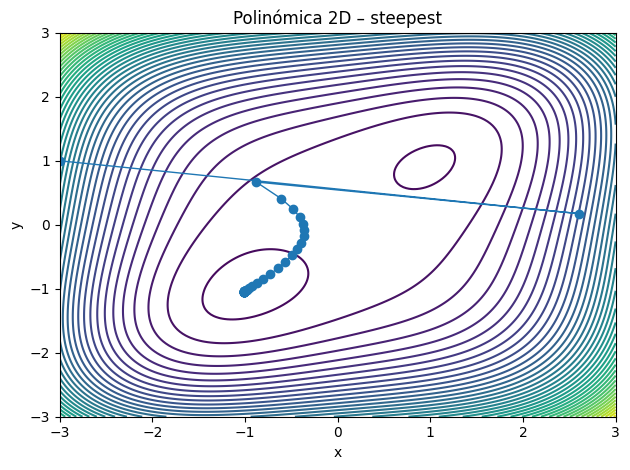

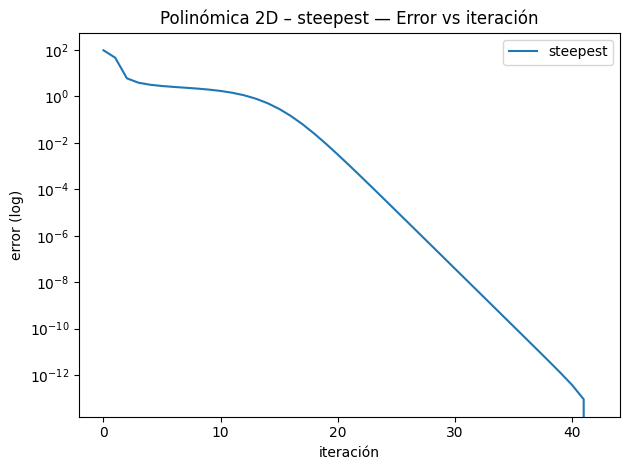

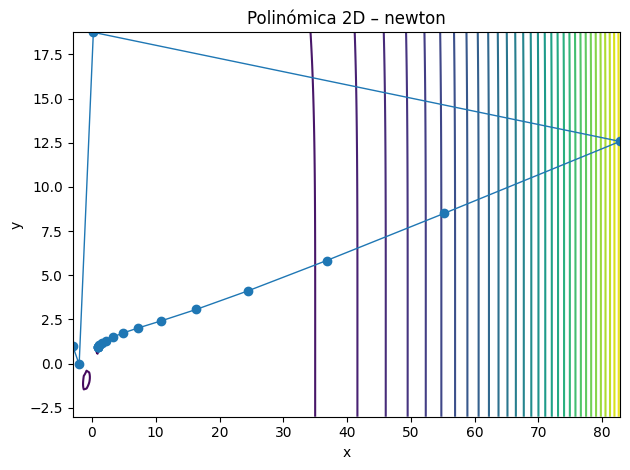

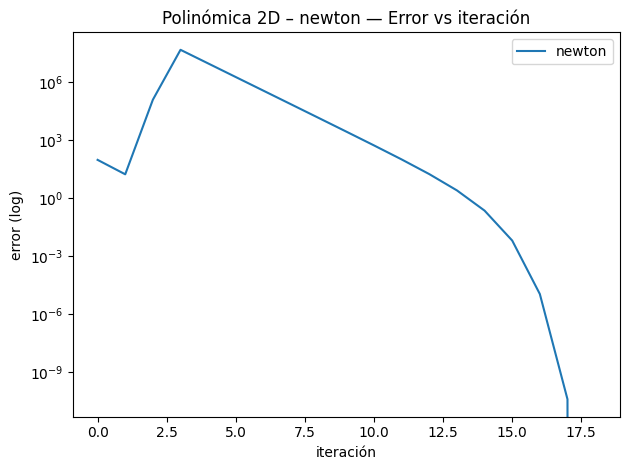

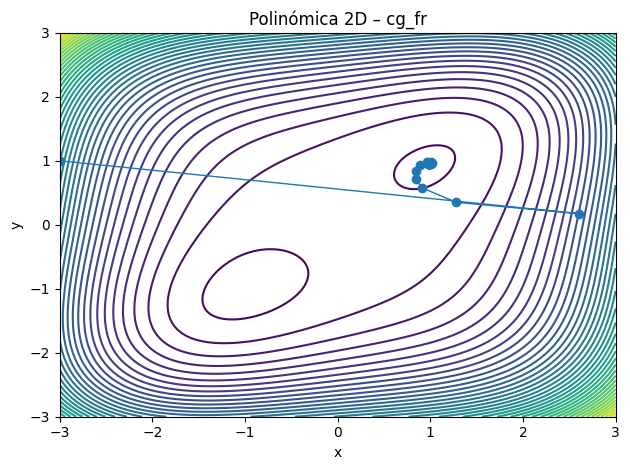

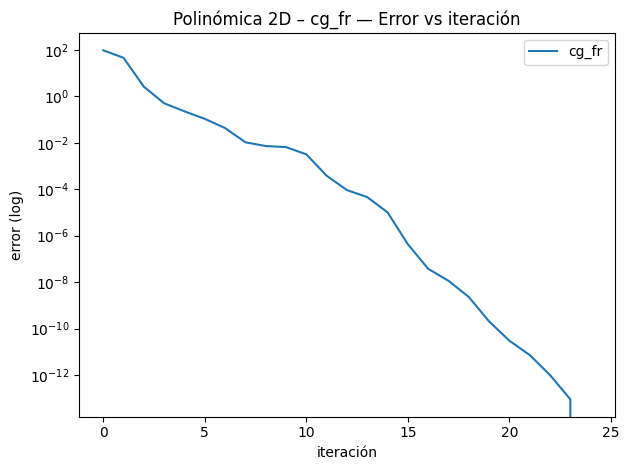

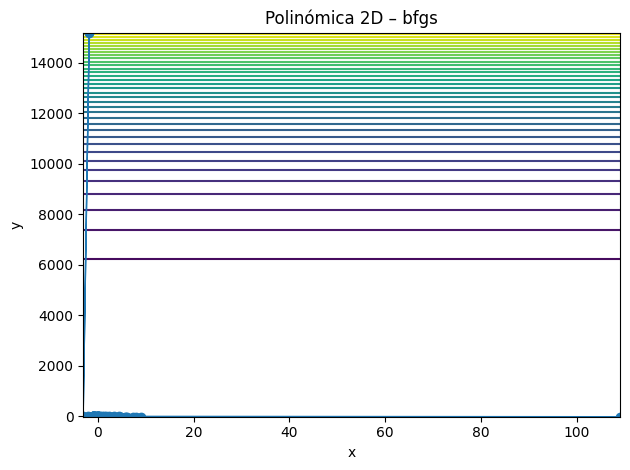

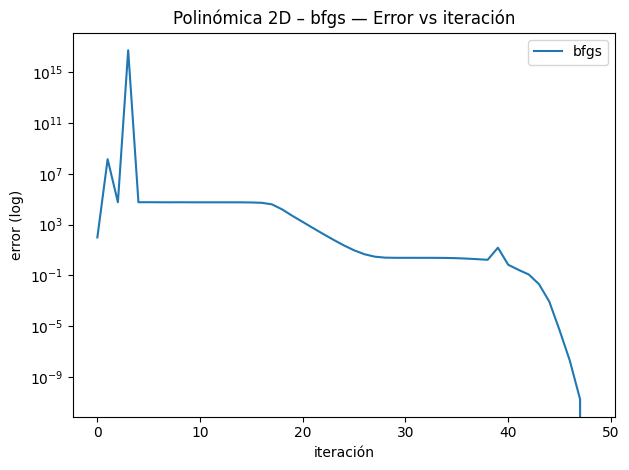

C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:21: RuntimeWarning: overflow encountered in scalar power
  return 100.0*(x2 - x1**2)**2 + (1.0 - x1)**2
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:25: RuntimeWarning: overflow encountered in scalar power
  d1 = -400*x1*(x2 - x1**2) - 2*(1 - x1)
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:26: RuntimeWarning: overflow encountered in scalar power
  d2 =  200*(x2 - x1**2)
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:25: RuntimeWarning: overflow encountered in scalar multiply
  d1 = -400*x1*(x2 - x1**2) - 2*(1 - x1)
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  return 100.0*(x2 - x1**2)**2 + (1.0 - x1)**2
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:25: RuntimeWarning: invalid value encountered in scalar subtract
  d1 = -400*x1*(x2

(rosen2) método newton: α* = 0.05
(rosen2) método bfgs: α* = 0.05

=== TABLA – Rosenbrock 2D ===
          metodo |     convergencia |      iteraciones |           f(sol) |    ||grad||(sol) |     ||sol - x*||
---------------------------------------------------------------------------------------------------------------
       gd_random |               No |                1 |              nan |              nan |                —
        steepest |               No |                1 |              nan |              nan |                —
          newton |               Sí |              444 |     5.024568e-14 |              nan |     4.993546e-07
           cg_fr |               No |                1 |              nan |              nan |                —
            bfgs |               Sí |              998 |     1.494195e-14 |              nan |     2.693974e-07


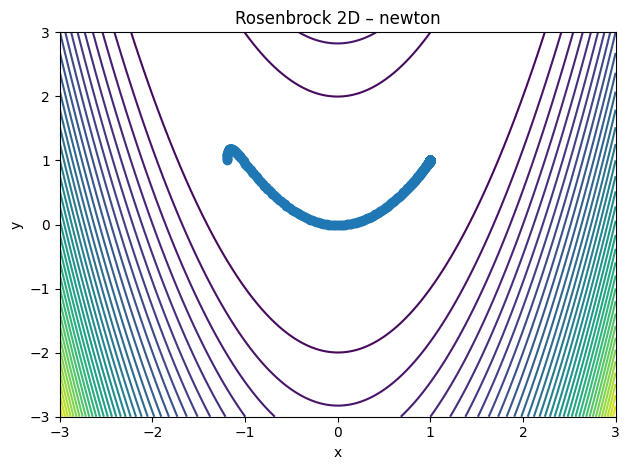

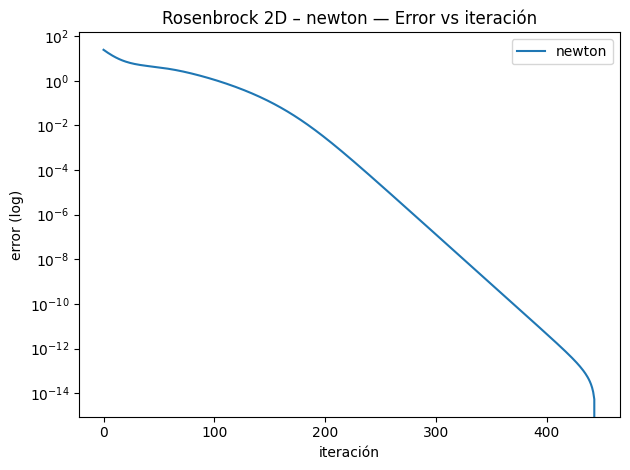

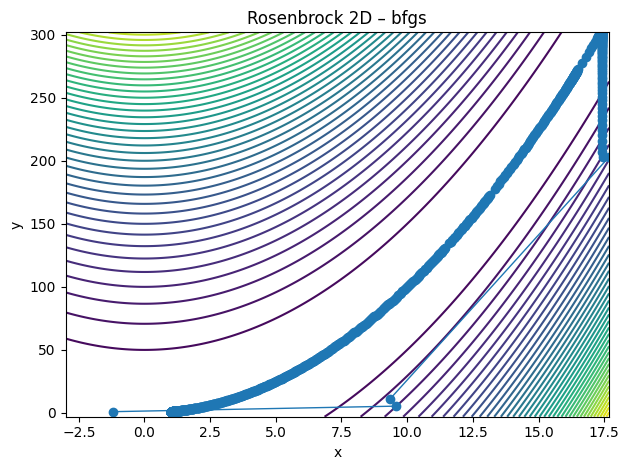

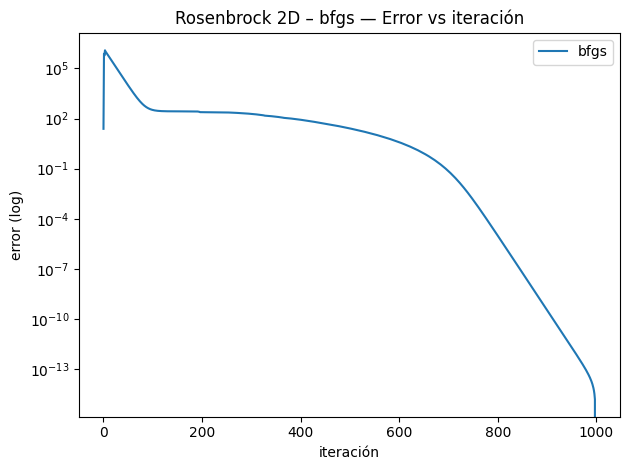

C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:41: RuntimeWarning: invalid value encountered in scalar subtract
  s += 100.0*(x[i+1] - x[i]**2)**2 + (1.0 - x[i])**2
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:49: RuntimeWarning: invalid value encountered in scalar subtract
  g[i] += -400*x[i]*(x[i+1]-x[i]**2) - 2*(1 - x[i])
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:51: RuntimeWarning: invalid value encountered in scalar subtract
  g[i] += 200*(x[i] - x[i-1]**2)
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:41: RuntimeWarning: overflow encountered in scalar power
  s += 100.0*(x[i+1] - x[i]**2)**2 + (1.0 - x[i])**2
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:49: RuntimeWarning: overflow encountered in scalar power
  g[i] += -400*x[i]*(x[i+1]-x[i]**2) - 2*(1 - x[i])
C:\Users\Andy Ortega\AppData\Local\Temp\ipykernel_31496\2106737674.py:51: RuntimeWarning: overflow


=== TABLA – Rosenbrock 7D ===
          metodo |     convergencia |      iteraciones |           f(sol) |    ||grad||(sol) |     ||sol - x*||
---------------------------------------------------------------------------------------------------------------
       gd_random |               No |                1 |              nan |              nan |                —
        steepest |               No |                1 |              nan |              nan |                —
          newton |               No |                1 |              nan |              nan |                —
           cg_fr |               No |                1 |              nan |              nan |                —
            bfgs |               No |                1 |              nan |              nan |                —


In [5]:
# Corre cada problema y genera tablas + gráficas
best_poly2, rows_poly2   = run_poly2()
best_rosen2, rows_rosen2 = run_rosen2()

# 7D sin Newton:
best_rosen7, rows_rosen7 = run_rosen7(use_newton_7d=False)

### **Ejercicio 3**

Centros generados (fijos):
 [[2.99632095 7.60571445]
 [5.85595153 4.78926787]
 [1.24814912 1.24795616]
 [0.4646689  6.92940917]
 [4.80892009 5.66458062]
 [0.16467595 7.75927882]
 [6.65954113 1.69871289]
 [1.45459974 1.46723608]]


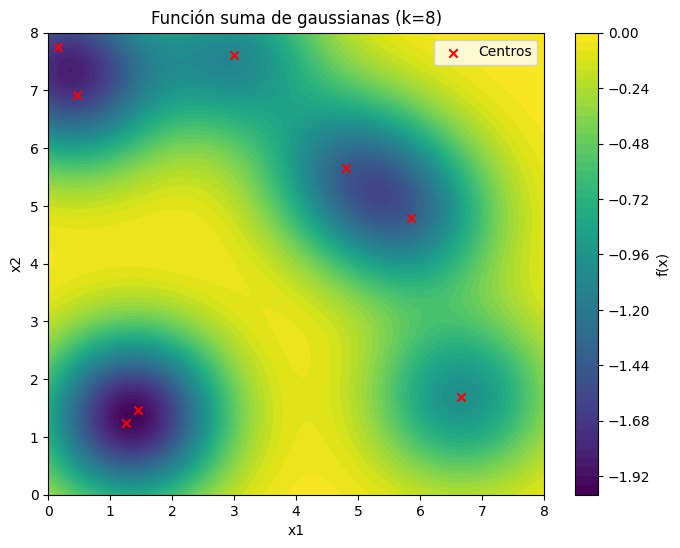

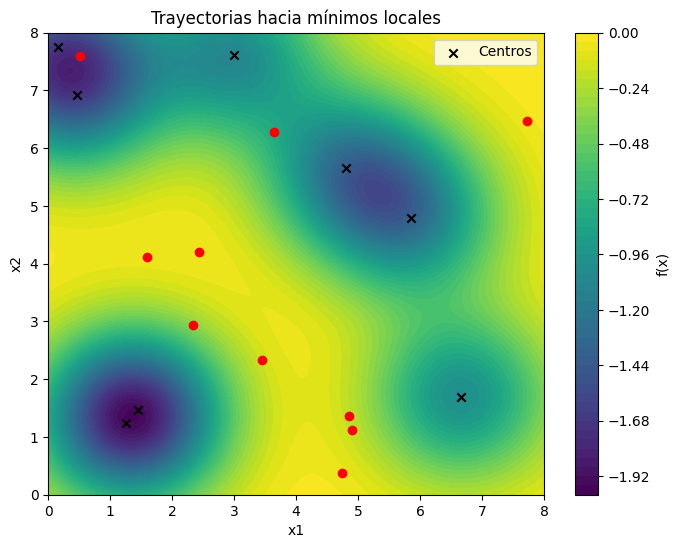


Mínimos locales encontrados:


,x1,x2,f(x)
0,2.433938,4.198051,-0.050149
1,3.455560,2.329833,-0.150937
2,4.894823,1.115951,-0.182418
3,2.337157,2.930895,-0.367807
4,3.648560,6.281408,-0.792668
5,1.597390,4.113876,-0.058443
6,4.739317,0.371603,-0.069656
7,4.860359,1.364193,-0.193700
8,0.520413,7.591084,-1.774313
9,7.725056,6.467179,-0.052991


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

k = 8                
sigma = 1.0          
np.random.seed(42)   
centros = np.random.uniform(0, 8, (k, 2))
print("Centros generados (fijos):\n", centros)

def f(x):
    """Función suma de gaussianas negativas"""
    x = np.array(x)
    return -np.sum(np.exp(-(1/(2*sigma)) * np.sum((x - centros)**2, axis=1)))

def grad_f(x):
    """Gradiente de f(x)"""
    x = np.array(x)
    dif = x - centros
    exp_terms = np.exp(-(1/(2*sigma)) * np.sum(dif**2, axis=1))
    grad = np.sum((dif / sigma) * exp_terms[:, None], axis=0)
    return grad * (-1)

X = np.linspace(0, 8, 200)
Y = np.linspace(0, 8, 200)
XX, YY = np.meshgrid(X, Y)
Z = np.array([[f([xx, yy]) for xx, yy in zip(row_x, row_y)] for row_x, row_y in zip(XX, YY)])

plt.figure(figsize=(8,6))
plt.contourf(XX, YY, Z, levels=50, cmap="viridis")
plt.colorbar(label="f(x)")
plt.scatter(centros[:,0], centros[:,1], c="red", marker="x", label="Centros")
plt.title("Función suma de gaussianas (k=8)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

iniciales = np.random.uniform(0, 8, (10, 2))  
minimos = []

plt.figure(figsize=(8,6))
plt.contourf(XX, YY, Z, levels=50, cmap="viridis")
plt.colorbar(label="f(x)")

for x0 in iniciales:
    res = minimize(f, x0, method="BFGS", jac=grad_f, options={"disp": False})
    minimos.append(res.x)
    
    plt.plot([x0[0], res.x[0]], [x0[1], res.x[1]], "w--", lw=1)
    plt.scatter(res.x[0], res.x[1], c="red", marker="o")

plt.scatter(centros[:,0], centros[:,1], c="black", marker="x", label="Centros")
plt.title("Trayectorias hacia mínimos locales")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

df_minimos = pd.DataFrame(minimos, columns=["x1", "x2"])
df_minimos["f(x)"] = [f(m) for m in minimos]
print("\nMínimos locales encontrados:")
display(df_minimos)


### **Ejercicio 4**

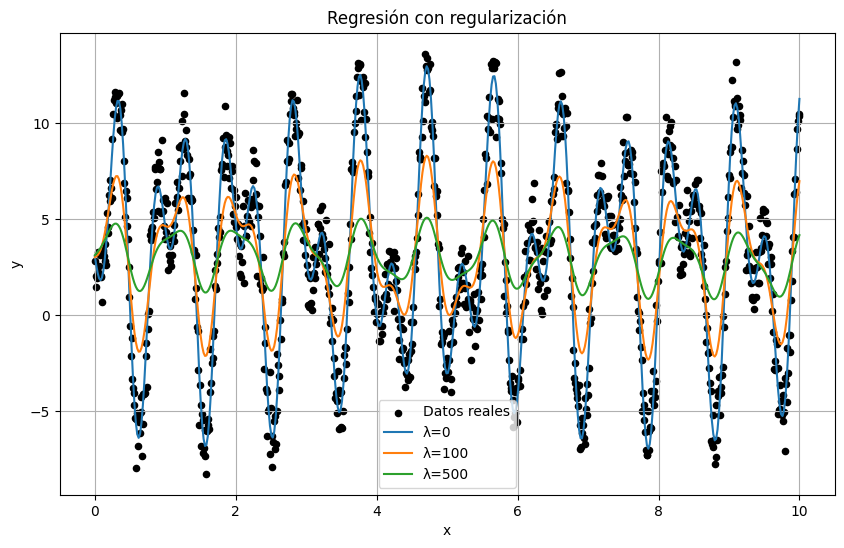


λ = 0, coeficientes β = [ 3.04870793e+00  1.46992338e-02 -3.46345308e-03  5.25038670e+00
 -4.66626183e+00]

λ = 100, coeficientes β = [ 3.00509168  0.05825492 -0.00927662  3.50050107 -1.72072679]

λ = 500, coeficientes β = [ 3.11807245  0.03613293 -0.00938222  1.50186973 -0.48634378]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

data = pd.read_csv("datos_lab3.csv")
x = data["x"].values
y = data["y"].values
n = len(x)


def modelo(beta, x):
    """Modelo: y = b0 + b1*x + b2*x^2 + b3*sin(7x) + b4*sin(13x)"""
    b0, b1, b2, b3, b4 = beta
    return b0 + b1*x + b2*(x**2) + b3*np.sin(7*x) + b4*np.sin(13*x)


def error_regularizado(beta, lam, x, y):
    
    pred = modelo(beta, x)
    error_datos = np.sum((pred - y)**2)
    
    
    diff = np.diff(pred)
    error_reg = np.sum(diff**2)
    
    return error_datos + lam*error_reg


lambdas = [0, 100, 500]
resultados = {}

for lam in lambdas:
    res = minimize(error_regularizado, x0=np.zeros(5), args=(lam, x, y))
    resultados[lam] = res.x  


plt.figure(figsize=(10,6))
plt.scatter(x, y, color="black", s=20, label="Datos reales")

x_plot = np.linspace(min(x), max(x), 500)

for lam in lambdas:
    beta_opt = resultados[lam]
    y_pred = modelo(beta_opt, x_plot)
    plt.plot(x_plot, y_pred, label=f"λ={lam}")

plt.title("Regresión con regularización")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


for lam, beta_opt in resultados.items():
    print(f"\nλ = {lam}, coeficientes β = {beta_opt}")
